# Quality Assessment
Now it's your turn. Follow [the steps on the platform](https://platform.wbscodingschool.com/courses/data-science/9474/) and use what you've learned to see how reliable the data is.

In [11]:
import pandas as pd

Load our cleaned DataFrames.

In [12]:
# orders_cl.csv
url = "https://drive.google.com/file/d/1Tla62vfu__kCqvgypZyVt2S9VuC016yH/view?usp=sharing" 
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orders_cl = pd.read_csv(path)

# orderlines_cl.csv
url = "https://drive.google.com/file/d/1OhtkQS2fwOYdzfd-qPh7im35iLc-L9TA/view?usp=sharing" 
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orderlines_cl = pd.read_csv(path)

# products_cl.csv
url = "https://drive.google.com/file/d/1s7Lai4NSlsYjGEPg1QSOUJobNYVsZBOJ/view?usp=sharing" 
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
products_cl = pd.read_csv(path)

## 1.&nbsp; Define Pandas display format

In [13]:
#pd.set_option("display.float_format", lambda x: "%.2f" % x)
pd.set_option("display.max_rows", 1000)

## 2.&nbsp; Exclude unwanted orders

### Include only real purchases

Let's create a copy of the `orders_cl` DataFrame, to make sure any of our changes won't affect the original DataFrame.

We will call it `orders_qu` to indicate that the quality assessment steps are reflected in it.

In [14]:
orders_qu = orders_cl.copy()

Let's look at the `state` column.

In [15]:
orders_qu["state"].value_counts()

Shopping Basket    117809
Completed           46605
Place Order         40883
Pending             14374
Cancelled            7233
Name: state, dtype: int64

It looks like an ovewhelming amount of the orders are left in the shopping basket! This is something we will have to analyse another time.

For this task, we are only interested in `Completed` orders, so let's filter our DataFrame.

In [16]:
orders_qu = orders_qu.loc[orders_qu["state"] == "Completed",:]

In [17]:
orders_qu["state"].value_counts()

Completed    46605
Name: state, dtype: int64

Next, we will make a list that contains all the `order_id`s of the `Completed` orders.

In [18]:
completed_list = list(orders_qu["order_id"])

Now we can filter our cleaned DataFrames to include only the `order_id`s in the list we just made.

In [19]:
orders_qu = orders_qu.loc[orders_qu["order_id"].isin(completed_list), :].copy()

In [20]:
orderlines_qu = orderlines_cl.loc[orderlines_cl["id_order"].isin(completed_list), :].copy()

### Keep only the orders that are present in both `orders` and `orderlines`
Let's begin by looking if there is a big difference between the amount of orders present in `orders` and `orderlines`.

In [21]:
len(orders_qu["order_id"].unique())

46605

In [22]:
len(orderlines_qu["id_order"].unique())

43064

The `orders` table contains more than 3000 more orders than the `orderlines`table! That means that some of the orders with status `completed`are not represented in the orderlines table. Let's fix that.

We will perform an inner merge on the two tables using the `order_id` and `id_order`. This will then keep only the `order_id`s that are present in both tables. As a next step, this will help us to filter our `_qu` DataFrames once more.

In [23]:
orders_lines_merged = orders_qu.merge(orderlines_qu, how="inner", left_on="order_id", right_on="id_order")

In [24]:
both_list = list(orders_lines_merged["order_id"].unique())

In [25]:
orders_qu = orders_qu.loc[orders_qu["order_id"].isin(both_list), :]
orderlines_qu = orderlines_qu.loc[orderlines_cl["id_order"].isin(both_list), :]

Let's have a quick check to make sure that the filter works on both DataFrames. They should both contain the same number of unique `order_id`s.

In [26]:
len(orders_qu["order_id"].unique()), len(orderlines_qu["id_order"].unique())

(43064, 43064)

## 3.&nbsp; Exclude orders with unknown products
Let's start by making a list of known products.

In [27]:
known_skus_list = list(products_cl["sku"])

Let's have a look to see how many products in our `orderlines_qu` DataFrame are known and how many are unknown.

In [28]:
orderlines_qu["sku"].isin(known_skus_list).value_counts()

True     55320
False     1394
Name: sku, dtype: int64

Looks like the vast majority of products is known. 

We can't simply delete the rows containing unknown products. Instead, we need to remove the entirety of any order that contains an unknown product. 

The first step is to identify all the orders that contain an unknown product. Then, find the `order_id` of these orders. Finally, filter these order numbers out of our `_qu` DataFrames.

In [29]:
orders_unknown_products_list = list(orderlines_qu.loc[~orderlines_qu["sku"].isin(known_skus_list), "id_order"])

Now we can filter our DataFrame to exclude the `order_id`s that contain unknown products.

In [30]:
orders_qu = orders_qu.loc[~orders_qu["order_id"].isin(orders_unknown_products_list), :]
orderlines_qu = orderlines_qu.loc[~orderlines_qu["id_order"].isin(orders_unknown_products_list), :]

Let's have a quick check to make sure we're filtering both DataFrames the same. They should both contain the same number of unique `order_id`s.

In [31]:
len(orders_qu["order_id"].unique()), len(orderlines_qu["id_order"].unique())

(41701, 41701)

## 4.&nbsp; Explore the revenue from different tables

In [32]:
orderlines_qu.head(3)

,id,id_order,product_id,product_quantity,sku,unit_price,date
6,1119116,299545,0,1,OWC0100,47.49,2017-01-01 01:46:16
7,1119119,299546,0,1,IOT0014,18.99,2017-01-01 01:50:34
8,1119120,295347,0,1,APP0700,72.19,2017-01-01 01:54:11


Step 1:
Create the `unit_price_total` as `orderlines.unit_price` * `orderlines.product_quantity`.

In [33]:
orderlines_qu["unit_price_total"] = orderlines_qu["product_quantity"] * orderlines_qu["unit_price"]

In [34]:
orderlines_qu.head(3)

,id,id_order,product_id,product_quantity,sku,unit_price,date,unit_price_total
6,1119116,299545,0,1,OWC0100,47.49,2017-01-01 01:46:16,47.49
7,1119119,299546,0,1,IOT0014,18.99,2017-01-01 01:50:34,18.99
8,1119120,295347,0,1,APP0700,72.19,2017-01-01 01:54:11,72.19


Step 2: Group by `order_id`, summarising by the sum of `unit_price_total` to get the total revenue for each order.

In [35]:
orderlines_qu_groupby = orderlines_qu.groupby("id_order", as_index=False)["unit_price_total"].sum()

In [36]:
orderlines_qu_groupby.head()

,id_order,unit_price_total
0,241423,129.16
1,242832,10.77
2,243330,77.99
3,245275,149.00
4,245595,105.98


### What is the average difference between `total_paid` and `unit_price_total`?

Let's merge our grouped `orderlines` table with the `orders` table, so we can calculate the differences in prices.

In [37]:
merged = orders_qu.merge(orderlines_qu_groupby, left_on="order_id", right_on="id_order")

In [38]:
# Create a new column with the difference between total_paid and unit_price_total.
merged["difference"] = merged["total_paid"] - merged["unit_price_total"]

In [39]:
# Show the 3 orders with the largest differences.
merged.nlargest(3, "difference")

,order_id,created_date,total_paid,state,id_order,unit_price_total,difference
97,297148,2017-01-01 16:42:24,4069.54,Completed,297148,84.55,3984.99
81,293308,2017-01-01 13:33:43,2635.47,Completed,293308,66.49,2568.98
39153,512894,2018-02-16 13:25:30,3356.18,Completed,512894,1674.60,1681.58


In [40]:
# Show the 3 orders with the smallest differences.
merged.nsmallest(3, "difference")

,order_id,created_date,total_paid,state,id_order,unit_price_total,difference
23757,432303,2017-11-22 21:43:02,261.86,Completed,432303,426.86,-165.00
74,289685,2017-01-09 23:15:07,15.95,Completed,289685,135.97,-120.02
5075,319901,2017-02-04 16:09:34,60.43,Completed,319901,142.44,-82.01


Now that we know the difference for each order, we can compute the average.

In [41]:
merged["difference"].mean().round(2)

4.47

### What is the distribution of these differences?

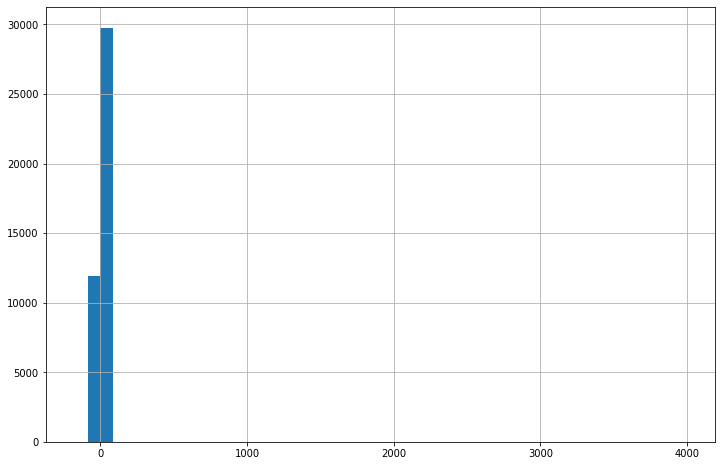

In [42]:
merged["difference"].hist(bins= 50, figsize=(12,8));

Looking at the spread of the data above, there seem to be some very high values! Likely, some of these differences are due to corruption. Let's use `.describe()` to investigate the distribution further.

In [43]:
merged["difference"].describe()

count    41701.000000
mean         4.474808
std         26.046478
min       -165.000000
25%          0.000000
50%          4.990000
75%          6.990000
max       3984.990000
Name: difference, dtype: float64

We can see from the our quartiles (0.00, 4.99, 6.99) that most of our data fits an expected pattern - free, 4.99, and 6.99 all seem like reasonable prices to assume as postage. However, look at the min and the max values, -165.00 and 3984.99, this can only occur due to corrupted data.

### Can all the differences be explained by shipping costs? If not, what are other plausible explanations?

What reasons have you come up with to explain the difference?

### If there are differences that you can’t explain: what should you do with these orders?
There's a rule of thumb, that anything: 
+ lower than the 25% quartile - (1.5 x interquartile range), or 
+ higher than the 75% quartile + (1.5 x interquartile range) 

is an outlier. Let's use this rule to try and exclude any corrupted data.

In [44]:
# Calculate the quartiles.
Q1 = merged["difference"].quantile(0.25)
Q3 = merged["difference"].quantile(0.75)
Q1, Q3

(0.0, 6.989999999999981)

In [45]:
# Calculate the interquartile range.
IQR = Q3-Q1

# Filter the DataFrame to include only "non-outliers".
merged_no_outliers = merged.loc[(merged["difference"] >= (Q1 - 1.5*IQR)) & (merged["difference"] <= (Q3 + 1.5*IQR)), :]

Let's look at the distribution again to see the affect of removing the outliers.

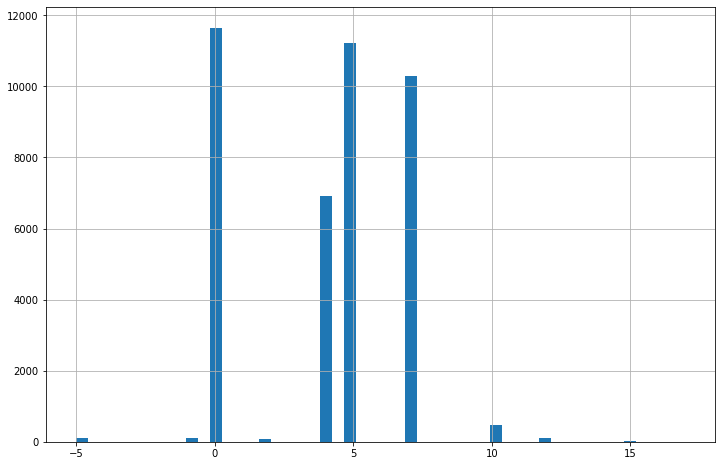

In [46]:
merged_no_outliers["difference"].hist(bins= 50, figsize=(12,8));

This looks much more like what we would expect: a small difference, but nothing extreme.

Now we need to remove these orders with extreme differences from our DataFrames.

In [47]:
# Create list with order ids of those orders that have a "normal" difference.
normal_diff_list = list(merged_no_outliers["order_id"])

In [48]:
# Only keep the orders with order ids in the normal_diff_list.
orders_qu = orders_qu.loc[orders_qu["order_id"].isin(normal_diff_list), :]
orderlines_qu = orderlines_qu.loc[orderlines_cl["id_order"].isin(normal_diff_list), :]

In [49]:
# Check whether orders and orderlines still have the same number of orders.
len(orders_qu["order_id"].unique()), len(orderlines_qu["id_order"].unique())

(40985, 40985)

## 5.&nbsp; Become confident about your dataset

Let's hear your thoughts about what you discovered.

Let's not forget to download our quality controlled DataFrames.

In [50]:
from google.colab import files

orders_qu.to_csv("orders_qu.csv", index=False)
files.download("orders_qu.csv")

orderlines_qu.to_csv("orderlines_qu.csv", index=False)
files.download("orderlines_qu.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>